Name 1: Sayeh Jarollahi<br>
Student id 1: 7073520<br>
Email 1: saja00006@stud.uni-saarland.de<br>

Name 2: Mahsa Amani<br>
Student id 2: 7064006 <br>
Email 2: maam00002@stud.uni-saarland.de <br>

# Implementation of RNN from Scratch (6 points)


In [1]:
import numpy as np 
import pandas as pd 
import re
import math
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

## Building Corpus and Vocabulary (1 point)


In the following code cells, we provide a simple method to build a corpus and vocabulary based on the data we have. Before reviewing them and answering the following questions:
1. (0.5 Points) Differentiate between corpus and vocabulary.

A corpus is a large, structured collection of text used for training models, including all words, phrases, and sentences in the dataset. In contrast, a vocabulary is a unique set of words extracted from the corpus, usually following preprocessing steps like lowercasing, punctuation removal, and exclusion of rare words. The vocabulary includes the distinct words the model will use and is significantly smaller than the entire corpus.

2. (0.5 Points) The `<unk>` token is widely used in NLP tasks; explain the intuition behind using this token.

The `<unk>` token represents "unknown" and is used to manage out-of-vocabulary (OOV) words in NLP tasks. As models are trained on a limited vocabulary from the training data, they may face words in test data or new inputs that were not included during training. Instead of failing, the model substitutes these unseen words with the `<unk>` token, enabling it to generalize and process input beyond its training vocabulary. This enhances robustness when encountering unexpected or rare words.

In [3]:
def read_data(path='./data/timemachine.txt'):
    with open(path, "r") as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
lines = read_data()
len(lines)

3617

In [6]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)

In [7]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [8]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('and', 2), ('of', 3), ('i', 4), ('a', 5), ('to', 6), ('in', 7), ('was', 8), ('that', 9)]


In [9]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_data()
    tokens = tokenize(lines, 'word')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [token for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)


(35850, 4937)

## Data Loader

In [10]:
def loader(corpus, num_steps=4, batch_size=32):
    corpus = corpus[random.randint(0, num_steps-1):]
    num_subseqs = (len(corpus) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return vocab[corpus[pos: pos+num_steps]]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):

        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

class SeqLoader:
    def __init__(self, corpus=corpus, vocab=vocab, num_steps=4, batch_size=32):
        self.corpus = corpus
        self.vocab = vocab
        self.num_steps = num_steps
        self.batch_size = batch_size

    def __iter__(self):
        return loader(self.corpus, self.num_steps, self.batch_size)

train_iter = SeqLoader(corpus)

### One-Hot Encoding



Note that each token is represented by a numerical index in `train_iter`. Directly feeding these indices into the neural network would make learning difficult. Therefore, each token is typically represented as a feature vector that carries more information. The simplest method is to use a one-hot encoding representation

In short, we map each index to a unique unit vector: suppose the number of unique tokens in the vocabulary is $N$  (len(vocab)) and their indices range from 0 to  $N−1$ . For a token with index $i$ , we create a vector of length  $N$ with all elements set to 0, except for the element at position $i$  which is set to 1. This vector is the one-hot vector of the original token. One-hot vectors for indices 0 and 2 are illustrated below.

In [11]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])

The minibatch size we sample each time is (batch size, time steps). The `one_hot` function transforms such a minibatch into a 3-dimensional tensor with the size of the last dimension equal to the vocabulary size. We often transpose the input to produce an output with the shape (time steps, batch size, vocabulary size), which is more suitable for feeding into a sequence model.

In [12]:
def one_hot(X, vocab_size):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, vocab_size).type(torch.float32)


## RNN Model (2 points)



<p align="center">
<img src="./data/architecture_RNN.png"/>

</p>

First, we initialize the hidden state using the `init_rnn_state` function. This function returns a tuple containing an ndarray filled with zeros and with a shape of (batch size, number of hidden units). Returning a tuple makes it easier to handle situations where the hidden state contains multiple variables (e.g., when we need to initialize multiple layers combined in an RNN).


In [13]:
def init_rnn_state(batch_size, num_hiddens, device):
    # Init H_0
    return (torch.zeros((batch_size, num_hiddens), device=device),)

### Initializing the Model Parameters (1 point)
Next, we initialize the parameters for the RNN model. The number of hidden units `num_hiddens` is a tunable parameter. When training the language model in this case, both the inputs and outputs rely on the same vocabulary, so they will have the same dimension (which is equal to the vocabulary size).



In this section, you are required to initialize the parameters for the RNN model (and don't forget to normalize them) based on the knowledge learned from the lecture and the architecture diagram provided above. 

Replace `NotImplemented` with your code.

In [14]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hy = normal((num_hiddens, num_outputs))
    b_y = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hy, b_y]
    for param in params:
        param.requires_grad_(True)
    return params

### Forward function (1 Point)
The following `rnn` function defines how to compute the hidden state and output at each time step. The activation function used here is tanh. The average value of the tanh function is 0 when the elements are evenly distributed on the real number line.

Replace `NotImplemented` with your code.



In [15]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hy, b_y = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        # Compute the hidden state H and output Y at each time step
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hy) + b_y
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

After defining all the functions, we create a class to encapsulate these functions and store the parameters.


In [16]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def parameters(self):
        for param in self.params:
            yield param

    def __call__(self, X, state):
        X = one_hot(X, vocab_size=self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

The output size is (number of time steps × batch size, vocabulary size), while the hidden state size remains unchanged at (batch size, number of hidden units).



### Prediction

First, we explain the prediction function, which is commonly used for testing during training. This function predicts the next `num_predicts` tokens based on the `input_sentence` (a string containing a few tokens). For the first tokens in the sequence, we only update the hidden state and then start generating new tokens.


In [17]:
def predict(model, input_sentence, device, num_preds=[5, 10]):
    outputs = []
    for num_pred in num_preds:
        input_words = input_sentence.split()
        output_words = input_words.copy()
        state = model.begin_state(batch_size=1, device=device)
        for input_word in input_words[:-1]:
            word_index = torch.tensor(vocab[input_word], device=device).reshape((1, 1))
            _, state = model(word_index, state)

        word = input_words[-1]
        for _ in range(num_pred):
            word_index = torch.tensor(vocab[word], device=device).reshape((1, 1))
            y, state = model(word_index, state)
            output_word = vocab.to_tokens(int(y.argmax(dim=1).reshape(1)))
            output_words.append(output_word)
            word = output_word
        outputs.append(output_words)
    return outputs

## Gradient Clipping (0.5 points)






For a sequence of length $T $, during a single backpropagation pass, the gradient is computed over $ T $ time steps, resulting in a sequence of matrix multiplications with a complexity of $O(T) $. When $ T $ is large, this can lead to numerical instability, manifesting as exploding or vanishing gradients. Therefore, RNN models often require some support to stabilize training.

Recall that in solving optimization problems, we update weights $ w $ in the direction opposite to the gradient $g_t $ for a minibatch, using the formula $ w - \eta \cdot g_t $. Suppose the objective function is Lipschitz continuous with constant $ L$, meaning:

$$
|l(\mathbf{w}) - l(\mathbf{w}')| \leq L \|\mathbf{w} - \mathbf{w}'\|.
$$

In this case, the change in the weight vector during an update of $ \eta \cdot g_t $ will not exceed $ L \eta \|g_t\| $. This has both advantages and disadvantages. The disadvantage is that the speed of optimization is limited, while the advantage is that the degree of deviation when optimizing in the wrong direction is also constrained.

Sometimes the gradient can become quite large, causing the optimization algorithm to fail to converge. This issue can be addressed by reducing the learning rate $ \eta $ or by employing certain techniques related to higher-order derivatives. However, if the gradient rarely becomes large, such approaches do not guarantee complete convergence. Another method is gradient clipping, where the gradient is projected onto a sphere of radius $ \theta $ using the formula:

$$
\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.
$$

This ensures that the norm of the gradient does not exceed $ \theta $, and the clipped gradient maintains the same direction as the original gradient $ g $. Gradient clipping has the additional benefit of limiting the influence of any single minibatch (or any single sample) on the weights, making the model more stable. While it does not completely resolve the issue, it is a simple technique to mitigate the problem of exploding gradients.

Below, we define the gradient clipping function, which can be used for both the RNNModelScratch implemented from scratch and models built with Gluon. Note that the gradient norm is computed across all parameters.

Implement the following `grad_clipping` function below.

Replace `NotImplemented` with your code.


In [18]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training (2.5 points)


In this final section, you are required to design a train function to train the model above with the following requirements:

- This train function must provide different sampling methods (ways to sample the next tokens) for sequential data (random sampling and sequential sampling), which result in differences in how the hidden states are initialized.
- Clip the gradients before updating the model parameters. This ensures that the model does not diverge, even if the gradients explode at some point during training, and it effectively reduces the magnitude of the update step automatically.

When performing sequential sampling, we only initialize the hidden states at the beginning of each epoch. Since the  $i^{th}$  sample in the next minibatch is adjacent to the  $i^{th}$  sample in the current minibatch, we can directly use the current hidden state for the next minibatch, while detaching the gradients to compute them separately for each minibatch. In contrast, when performing random sampling, we need to reinitialize the hidden states for each iteration of minibatch because each sample is drawn from a random position.

In [24]:
# Data
num_steps = 10
batch_size = 32
corpus, vocab = load_corpus_time_machine()
train_iter = SeqLoader(corpus, vocab, num_steps, batch_size)

# Initialize model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_hiddens = 512
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)

# Optimization
num_epochs = 500
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1)

#### (2.5 points) Write your `train` function that returns the trained model and the loss during training

You need to implement both the random sampling method and the sequential sampling method, and plot the loss function during the training process for both methods to earn points for this section.
- (2 points) Train function and training process 
    -  (1 point) Random sampling method
    -  (1 point) Sequential sampling method
- (0.5 points) The plot of the loss function during the training process 

In [22]:
def train(model, train_iter, device, criterion, optimizer, num_epochs, random_sampling=True):
    # Set random_sampling = True to perform random sampling method 
    # Set random_sampling = False then perform sequential sampling method
    def detach_hidden_state(hidden_state):
        return [h.detach() for h in hidden_state]

    losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        state = None
        num_batches = sum(1 for _ in train_iter)

        for X, Y in train_iter:
            if random_sampling or state is None:
                state = model.begin_state(batch_size=batch_size, device=device)
            else:
                state = detach_hidden_state(state)

            X, Y = X.to(device), Y.to(device)
            y_hat, state = model(X, state)
            y = Y.T.reshape(-1)
            loss = criterion(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            grad_clipping(model, 1)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Plot the loss
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

Training with random sampling...
Epoch 1/500, Loss: 7.1542
Epoch 2/500, Loss: 6.4909
Epoch 3/500, Loss: 6.3985
Epoch 4/500, Loss: 6.3216
Epoch 5/500, Loss: 6.2405
Epoch 6/500, Loss: 6.1705
Epoch 7/500, Loss: 6.1013
Epoch 8/500, Loss: 6.0437
Epoch 9/500, Loss: 5.9926
Epoch 10/500, Loss: 5.9366
Epoch 11/500, Loss: 5.8819
Epoch 12/500, Loss: 5.8431
Epoch 13/500, Loss: 5.8000
Epoch 14/500, Loss: 5.7604
Epoch 15/500, Loss: 5.7146
Epoch 16/500, Loss: 5.6783
Epoch 17/500, Loss: 5.6340
Epoch 18/500, Loss: 5.5963
Epoch 19/500, Loss: 5.5573
Epoch 20/500, Loss: 5.5229
Epoch 21/500, Loss: 5.4785
Epoch 22/500, Loss: 5.4569
Epoch 23/500, Loss: 5.4021
Epoch 24/500, Loss: 5.3783
Epoch 25/500, Loss: 5.3467
Epoch 26/500, Loss: 5.2938
Epoch 27/500, Loss: 5.2386
Epoch 28/500, Loss: 5.2374
Epoch 29/500, Loss: 5.1815
Epoch 30/500, Loss: 5.1709
Epoch 31/500, Loss: 5.0945
Epoch 32/500, Loss: 5.0590
Epoch 33/500, Loss: 5.0593
Epoch 34/500, Loss: 4.9953
Epoch 35/500, Loss: 4.9121
Epoch 36/500, Loss: 4.9379
Epoc

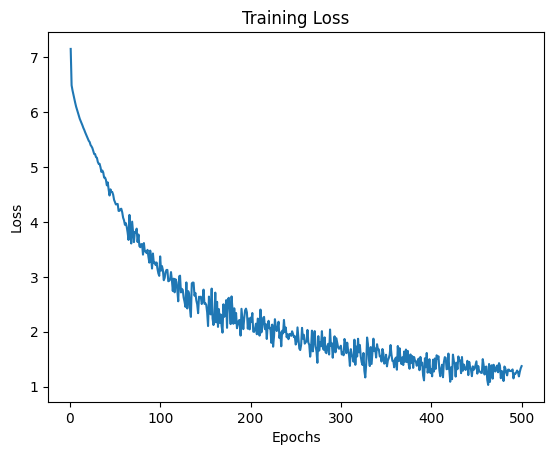

In [25]:
print("Training with random sampling...")
train(model, train_iter, device, criterion, optimizer, num_epochs, random_sampling=True)

Training with sequential sampling...
Epoch 1/500, Loss: 3.4485
Epoch 2/500, Loss: 3.3143
Epoch 3/500, Loss: 3.2562
Epoch 4/500, Loss: 3.2441
Epoch 5/500, Loss: 3.1028
Epoch 6/500, Loss: 2.9956
Epoch 7/500, Loss: 2.9917
Epoch 8/500, Loss: 2.9618
Epoch 9/500, Loss: 2.8873
Epoch 10/500, Loss: 2.7893
Epoch 11/500, Loss: 2.8515
Epoch 12/500, Loss: 2.7436
Epoch 13/500, Loss: 2.7787
Epoch 14/500, Loss: 2.6827
Epoch 15/500, Loss: 2.6838
Epoch 16/500, Loss: 2.6041
Epoch 17/500, Loss: 2.6384
Epoch 18/500, Loss: 2.5794
Epoch 19/500, Loss: 2.5393
Epoch 20/500, Loss: 2.5477
Epoch 21/500, Loss: 2.4739
Epoch 22/500, Loss: 2.4734
Epoch 23/500, Loss: 2.4042
Epoch 24/500, Loss: 2.4081
Epoch 25/500, Loss: 2.4820
Epoch 26/500, Loss: 2.4715
Epoch 27/500, Loss: 2.3850
Epoch 28/500, Loss: 2.3730
Epoch 29/500, Loss: 2.3931
Epoch 30/500, Loss: 2.3184
Epoch 31/500, Loss: 2.3551
Epoch 32/500, Loss: 2.2823
Epoch 33/500, Loss: 2.3385
Epoch 34/500, Loss: 2.3339
Epoch 35/500, Loss: 2.2388
Epoch 36/500, Loss: 2.3697


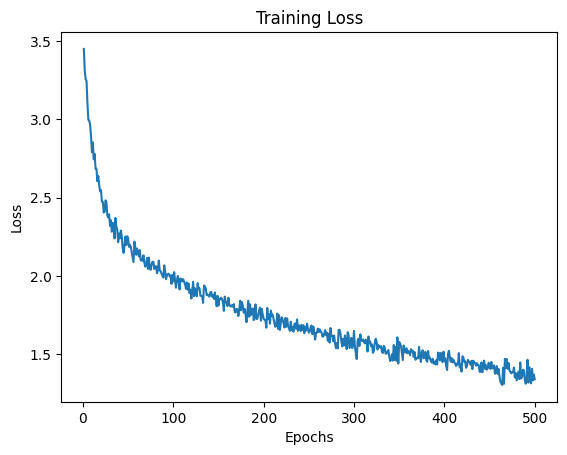

In [26]:
print("Training with sequential sampling...")
train(model, train_iter, device, criterion, optimizer, num_epochs, random_sampling=False)